# Insight Data Science New York Interview Demo


## Outline: 
1. Goal: Build a model that can classify the face images by names. Specifically, given an input face image, the Convolutional Neural Network (CNN) will give the name. 
2. Dataset: Olivatti face data.  Import / Visualize the dataset. 
3. Tool: Use Keras (API) to create CNN. The CNN is a category of Neural Networks that is effective in image recognition and classification. 
4. Exploratory data analysis: Visulization / Feature abstraction. 
5. Train and test the CNN model. 
6. Results. 


In [2]:
import numpy as np
import gzip
import os
import csv
import types

import matplotlib.pyplot as plt

from keras.layers import Conv2D
from keras.layers import MaxPool2D, AvgPool2D
from keras.layers import Flatten, Activation
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.layers import Activation
from keras.layers import Dense
from keras import optimizers

Using TensorFlow backend.
/Users/jingjingfeng/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)



## 2. Dataset
Olivetti face data. 40 different people's face. Each person has 10 faces with different facial expressions and angles. Totally there are 400 face images. 

300 images for training, 100 for testing. 

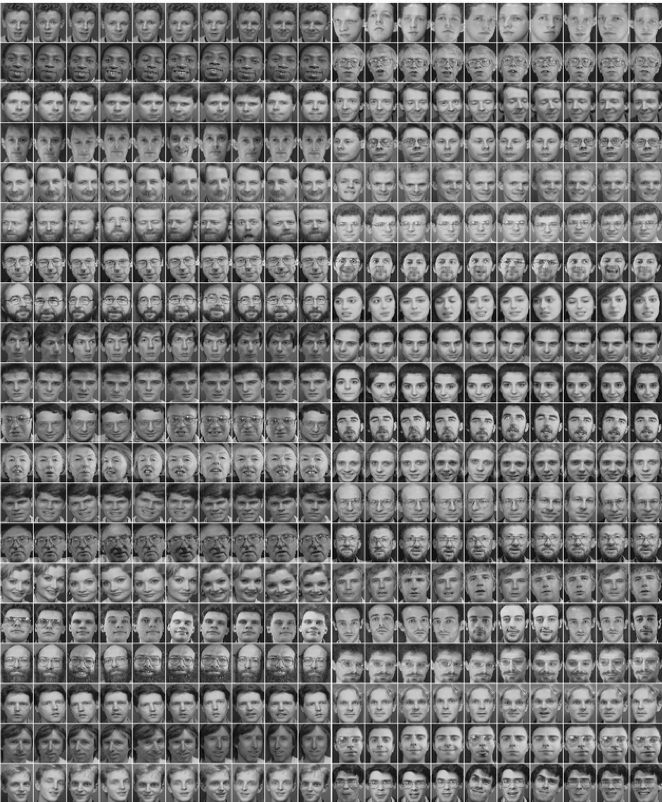

### Prepare / Import the dataset: 

In [8]:
# We define a function 'read_files_data_and_labels(input_dir)' that reads the directory that have images and label 
# to identify name of the person for Olivetti facedata. 

def read_files_data_and_labels(input_dir):
    
    # We first assign some empty arrays as holders. 
    # The 300/100 is the total number of pics for train and test, respectively. 
    # 10304 is the total number of pixels of each image. 40 is the size of the label. 
    data_train = np.empty([300, 10304]) # data_train is an array with each row representing the total pixels of a training image. 
    data_test = np.empty([100, 10304])
    label_train = np.zeros([300, 40])
    label_test = np.zeros([100, 40])

    # index in train and test group. The original value is 0. 
    train_index = 0
    test_index = 0

    # Now we read the name of each folder. 
    # We have totally 40 folders, i.e. 40 names. 
    # Each folder has a name 's1, s2, ... s39, s40' respectively, which is the name of the person. 
    # Each folder contains 10 face images of the same person. 
    # Note that folder means dirs in the code. 
    dirs = os.listdir(input_dir)  # input_dir is the directory of the folder in disk
    print("We have following people")
    print(dirs)
    print("\n")

    # We use the first 'for' loop to read each folder one by one. 
    for label in dirs:  # s1, s2, .... in the folder
        dir_name = input_dir + "/" + label  # dir_name = directory of the folder/s1
        dir_files = os.listdir(dir_name)   

        if os.path.isdir(dir_name):
        # Now we start with the first dir_name s1, and use a second 'for' loop to read each image in the folder one by one. 
            for file_name in dir_files:
                file_path = dir_name + "/" + file_name  # file_path = directory of folder/s1/1

                # Use "read file()" function (we will define later), we can import the image matrix as img_np. 
                # Meanwhile get the info of width and height of the image. 
                (img_np, width, height) = read_file(file_path)

                # Now we split data into training and testing data. 
                # Every four images we read, we pick one as test. The rest is for train
                if (train_index + test_index) % 4 == 0:
                    data_test[train_index, :] = img_np  # the original value of train_index is 0
                    label_test[train_index, :] = lookup_table_identify(label)
                    train_index = train_index + 1
                else:
                    data_train[test_index, :] = img_np
                    label_train[test_index, :] = lookup_table_identify(label)
                    test_index = test_index + 1
                    
    return (data_train, data_test, label_train, label_test, width, height)


### With previously defined functions 'read_files_data_and_labels', we now are able to import all the data, and assign the training and testing images with labels. 

In [13]:
(data_train, data_test, label_train, label_test , width, height) = read_files_data_and_labels("/Users/jingjingfeng/att_faces")

# Now let's see the size of the image
print ('The width of the image is ' + str (width) + " and height is " + str(height) + ', where 92 x 112 = 10304')

We have following people
['s1', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's2', 's20', 's21', 's22', 's23', 's24', 's25', 's26', 's27', 's28', 's29', 's3', 's30', 's31', 's32', 's33', 's34', 's35', 's36', 's37', 's38', 's39', 's4', 's40', 's5', 's6', 's7', 's8', 's9']


The width of the image is 92 and height is 112, where 92 x 112 = 10304



### Now we use one of the images as an example, see how the data looks like as a pixel array.

In [14]:
print ("Now we use the 8th image as an example, see what the image looks like as a pixel array i.e. data_holder")
print(data_train[7,:])
print ("We can see that we import the image as a 1D array\nThe length of the array is")
print( len(data_train[7,:]))
print("which is determined by the width x height pixels of the image\n")

Now we use the 8th image as an example, see what the image looks like as a pixel array i.e. data_holder
[ 140.  134.  135. ...,   25.   26.   49.]
We can see that we import the image as a 1D array
The length of the array is
10304
which is determined by the width x height pixels of the image




### Visualize the dataset: 
In the training process, we still want to train a real image in rectangular shape (2D image), so we need to reshape 1-D array to 2-D array.

Now we see what the data of 8th image looks like after reshape
[[[ 140.]
  [ 134.]
  [ 135.]
  ..., 
  [ 129.]
  [ 126.]
  [ 128.]]

 [[ 140.]
  [ 136.]
  [ 135.]
  ..., 
  [ 127.]
  [ 126.]
  [ 128.]]

 [[ 142.]
  [ 132.]
  [ 137.]
  ..., 
  [ 126.]
  [ 128.]
  [ 128.]]

 ..., 
 [[  63.]
  [  48.]
  [  47.]
  ..., 
  [  15.]
  [  26.]
  [  27.]]

 [[  42.]
  [  45.]
  [  48.]
  ..., 
  [  23.]
  [  24.]
  [  36.]]

 [[  43.]
  [  55.]
  [  43.]
  ..., 
  [  25.]
  [  26.]
  [  49.]]]


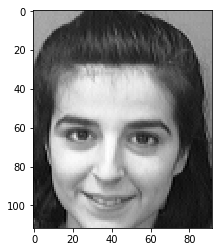

In [51]:
data_train_reshape = data_train.reshape(-1, height, width, 1)
data_test_reshape = data_test.reshape(-1, height, width, 1)

print("Now we see what the data of 8th image looks like after reshape")
print(data_train_reshape[7,:,:])
plt.imshow(data_train[7,:].reshape(height, width), cmap='gray')
plt.show()


## 3. Tool: Now we build the CNN. 


### Schetch of Convolutional Neural Network: 
6 Convolutional layers to abstract the input image (1st, 3rd, 5th layers). 5 fully connected layers as classifier (2nd, 4th, 6th layers). 

8 filters (2x2 matrix) in 1st layer (so one input pic becomes 8 pics). 16 filters (3x3 matrix) in 3rd layer. 32 filters (4x4 matrix) in 5th layer. 

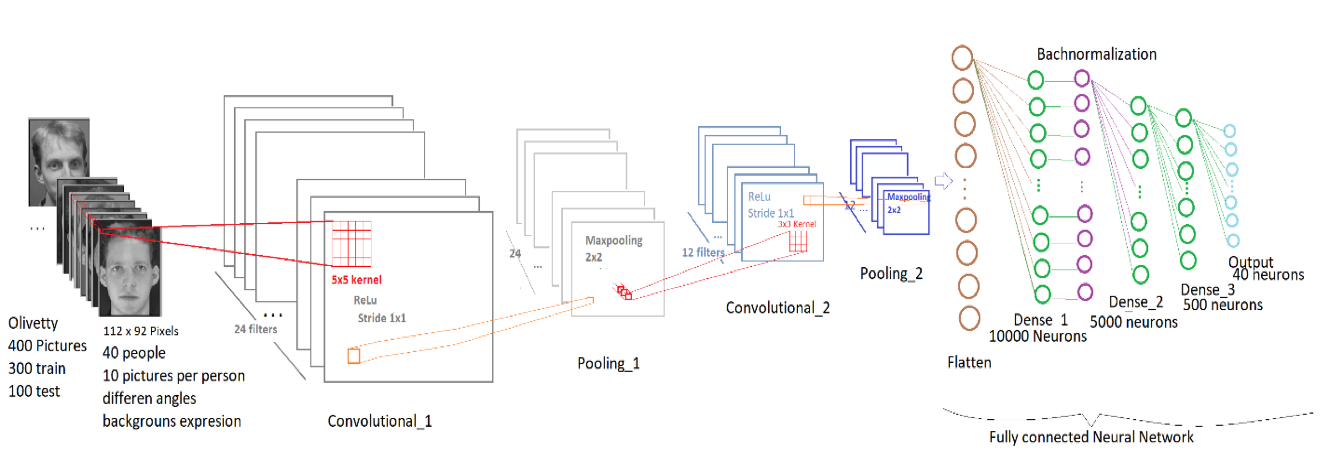

### There are 3 steps in the CNN model: 1). Convolution; 2). Pooling; 3). Classification.

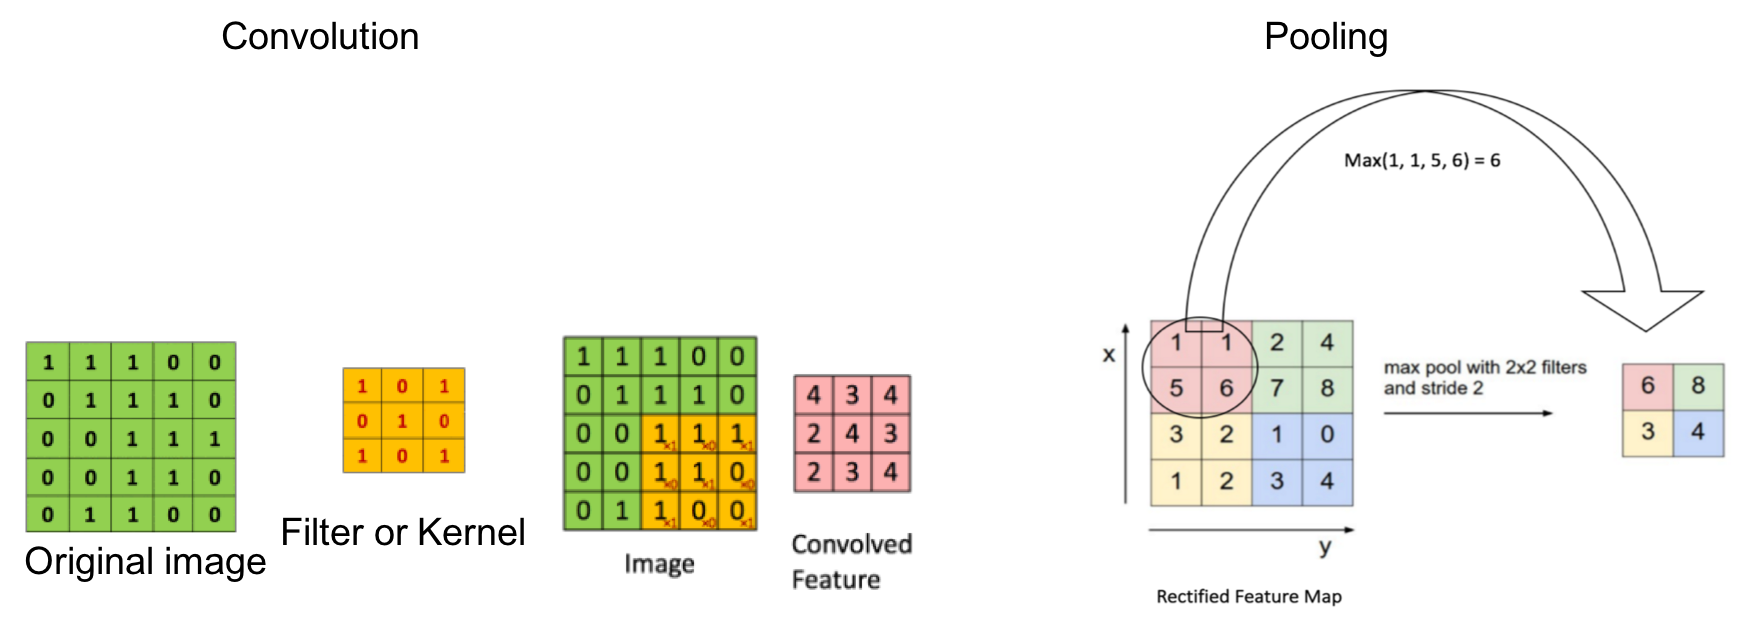

First two steps: The input image is abstracted into a feather map that highlights the feather with a low dimensional pixel array.   

The last step uses fully connected layers to classify the image into various classes. 

## 4. Exploratory data analysis: Visualize image after every convolutional layer. 

In [ ]:
# We define some tuning parameters that will be used in the model. 
# One epoch consists of one full training cycle on the training dataset.  
# 8 epoches. 50 batches per epoches. 


epochs = 8

kernel_1 = 2
kernel_2 = 3
kernel_3 = 4

filter_1 = 8
filter_2 = 16
filter_3 = 32

learning_rate = 0.00002
rmsprop_v = optimizers.RMSprop(lr=learning_rate)
adam_v = optimizers.Adam(lr=learning_rate)

In [39]:
# use 8th image for demo. Define 'visulize_face' function to visualize the image. 
Face=data_train[7,:].reshape(height, width)
def visulize_face(Face_from_last_Layer):
    Face_batch = np.expand_dims(Face_from_last_Layer, axis=2)
    Face_batch2=np.expand_dims(Face_batch,axis=0)
    conv_Face=model.predict(Face_batch2)
    Face_after_oneLayer = np.squeeze(conv_Face, axis=0)
    plt.imshow(Face_after_oneLayer[:, :, 0], cmap='gray')
    plt.show()

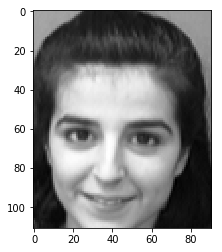

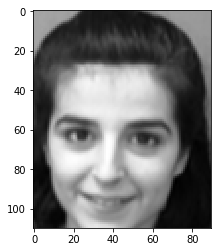

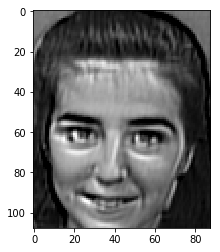

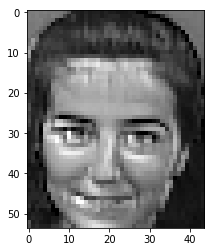

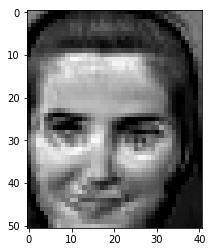

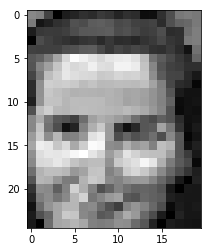

In [48]:
# Now we build the CNN model by adding multiple layers in a sequential order. 
model = Sequential() 

# 6 Convolutional layers. The Convolutional layers amplify the pixel element to reduce the image. 
model.add(Conv2D(filter_1, kernel_size=(kernel_1, kernel_1), strides=(1, 1), activation='relu', input_shape=(height, width, 1))) 
visulize_face(Face)

model.add(AvgPool2D(pool_size=(2, 2), strides=(1, 1)))
visulize_face(Face)

model.add(Conv2D(filter_2, (kernel_2, kernel_2), activation='relu'))
visulize_face(Face)

model.add(MaxPool2D(pool_size=(2, 2)))
visulize_face(Face)

model.add(Conv2D(filter_3, (kernel_3, kernel_3), activation='relu'))
visulize_face(Face)

model.add(MaxPool2D(pool_size=(2, 2)))
visulize_face(Face)

# 5 fully connected layers as classifier. 
# Here adds the fully connected layers (or called dense layer). 
# 'Flatten' converts the output of the convolutional part into a 1D feature vector. 
model.add(Flatten())
model.add(Dense(10000, activation='sigmoid'))  # logistic regression with sigmoid
model.add(BatchNormalization())  # how to choose how many neurons in FCL?
model.add(Dense(5000, activation='sigmoid'))
model.add(Dense(500,  activation='sigmoid'))

# The last layer is output layer for face recognition of 40 people (40 neurons). 
# Use softmax function to output its probabilities of what classes it is going to be, for a multi-class classification problem.
model.add(Dense(40,   activation='softmax'))  


### Convolution: acts as a filter for that image. Split a big image continuously into smaller subset of images to highlights the features (larger number in element). 

### Pooling: find out what part of the image is most relavent, that is what part of the image that has most drawing / characters on it. Blurs the image and amplify the pixel element. 


In [24]:
# Now we compile (or say combine) the model and show the summary. 
model.compile(loss='categorical_crossentropy', optimizer=rmsprop_v, metrics=['accuracy'])
print("this is model summary")
model_summary = model.summary()
print("this is model summary end \n\n")

this is model summary
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 111, 91, 8)        40        
_________________________________________________________________
average_pooling2d_2 (Average (None, 110, 90, 8)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 108, 88, 16)       1168      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 54, 44, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 51, 41, 32)        8224      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 25, 20, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 16000)            

## Summary of Compiling: 

### Six Convolutional layers to abstract the input image:  
In Convolutional layers: The 1st, 3rd, 5th layers are convolution process with filters. The 2nd, 4nd, 6nd layers are pooling process. 

8 filters (2x2 matrix) in 1st layer. 16 filters (3x3 matrix) in 3rd layer. 32 filters (4x4 matrix) in 5th layer. 

The Output Shape is the dimension of the output image in that layer. 

### Five fully connected layers as classifier:  
In fully connected layers: a flattened layer becomes the input of fully connected layers of the Neural Network: 4 hidden layers and 1 output layer. 

The Output Shape shows the number of neurons used in each layer. 



## 5. Train and test the CNN model. 

In [13]:
# Now Let's train the model using 'model.fit' (the gradient descent is included in)
print("Now Start Train")
task = model.fit(data_train_reshape, label_train, epochs=epochs, batch_size=50)
#
# Now Let's test the model's performance using 'model.evaluate'
print("\nNow Start Test")
x_val_performance = model.evaluate(data_test_reshape, label_test)
print("\nTest Result is")
print(x_val_performance)

Now Start Train
Epoch 1/8
300/300 [==============================] - 51s 171ms/step - loss: 3.6621 - acc: 0.0833
Epoch 2/8
300/300 [==============================] - 54s 178ms/step - loss: 3.2435 - acc: 0.3633
Epoch 3/8
300/300 [==============================] - 47s 157ms/step - loss: 2.9559 - acc: 0.5967
Epoch 4/8
300/300 [==============================] - 41s 136ms/step - loss: 2.7227 - acc: 0.7633
Epoch 5/8
300/300 [==============================] - 42s 140ms/step - loss: 2.5137 - acc: 0.8167
Epoch 6/8
300/300 [==============================] - 45s 151ms/step - loss: 2.2826 - acc: 0.9133
Epoch 7/8
300/300 [==============================] - 45s 150ms/step - loss: 2.0949 - acc: 0.9367
Epoch 8/8
300/300 [==============================] - 42s 139ms/step - loss: 1.9064 - acc: 0.9467
Now Start Test
100/100 [==============================] - 2s 22ms/step
Test Result is
[2.9528631401062011, 0.69999999999999996]


## 6. Results: 
1). The CNN model we built is simple and efficient in image classification by Keras. The training accuracy of this model is ~ 0.9, while the testing accuracy is ~ 0.7.  Average performance ~ 0.8. Very good but not perfect. Overfitting. Solve by increasing learning rate. 

2). The smaller dimension of the filter, the less reduction, the more comsumption of computation source. 

3). The larger number of the filter, the more feature can capture from the pic, the more comsumption of computation source. 

4). More number of filters get more image features extracted and better the network at recognizing patterns. 



## Impact: 
Applicable to image recognition in healthcare such as cancer cell identification, or in searching victims in avalanches. 

## Appendix

Look-up table for name label (classifier 40 people)

We created unique arrays to represent each name, in order to make computer easy to understand. 

In [5]:
def lookup_table_identify(label):
    return {
        's1': [1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        's2': [0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        's3': [0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        's4': [0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        's5': [0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        's6': [0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        's7': [0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        's8': [0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        's9': [0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        's10': [0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        's11': [0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        's12': [0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        's13': [0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        's14': [0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        's15': [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        's16': [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        's17': [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        's18': [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        's19': [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        's20': [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        's21': [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        's22': [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        's23': [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        's24': [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        's25': [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        's26': [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        's27': [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0],
        's28': [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0],
        's29': [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0],
        's30': [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0],
        's31': [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0],
        's32': [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0],
        's33': [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0],
        's34': [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0],
        's35': [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0],
        's36': [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0],
        's37': [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0],
        's38': [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0],
        's39': [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0],
        's40': [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]
    }[label]

## Appendix 

We mentioned in previous cell the function of read_file. This function read '.pgm' files in each folders and return the pixel array and the width and height of the image. 

In [ ]:
def read_file(file_path):
    fh = open(file_path, "rb")
    format = next(fh)

    fh.seek(len(format))
    header = next(fh)
    width_c, height_C = header.split()

    # print(width_c, height_C)
    width = int(width_c)
    height = int(height_C)
    fh.seek(len(header) + len(format))
    header1 = next(fh)
    maxval_c = header1
    maxval = int(maxval_c)
    # print(maxval)
    fh.seek(len(header1) + len(header) + len(format))
    img = np.fromfile(fh, dtype=np.uint8)
    
    fh.close()
    return (img, width, height)




## Appendix

Loss is a summation of the errors made for each example in training or validation sets. Loss value implies how well or poorly a certain model behaves after each iteration of optimization. Ideally, one would expect the reduction of loss after each, or several, iteration(s).

The accuracy of a model is usually determined after the model parameters are learned and fixed and no learning is taking place. Then the test samples are fed to the model and the number of mistakes (zero-one loss) the model makes are recorded, after comparison to the true targets. Then the percentage of misclassification is calculated. 

For example, if the number of test samples is 1000 and model classifies 952 of those correctly, then the model's accuracy is 95.2%.

Batch: Total number of training examples present in a single batch. You can’t pass the entire dataset into the neural net at once. So, you divide dataset into Number of Batches or sets or parts. 

Iterations is the number of batches needed to complete one epoch.

Learning rate is the rate to approach the local minimum during gradient decent. 